In [1]:
from numpy.lib.format import header_data_from_array_1_0
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import json
import data_cleaner
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Specify the directory path
directory_path = 'data/'

# Get a list of files in the directory
file_names = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
file_names

['Alcatel_data.json',
 'Apple_data.json',
 'Asus_data.json',
 'Blu_data.json',
 'HTC_data.json',
 'Huawei_data.json',
 'Infinix_data.json',
 'Lenovo_data.json',
 'LG_data.json',
 'Nokia_data.json',
 'Samsung_data.json',
 'Sony_data.json',
 'Xiaomi_data.json',
 'ZTE_data.json']

In [9]:
dataframes = []
for f in file_names:
    file_path = directory_path + f
    with open(file_path, 'r') as file:
        data = json.load(file)
    parsed_data = []
    for brand, products in data.items():
        for product_name, spec in products.items():
            if "watch" in product_name.lower():
                continue
            lunch_data = data_cleaner.parse_date(spec.get('Launch', list(dict())))
            if not lunch_data[1] or lunch_data[0] > 6:
                continue
            if lunch_data[1] == 2:
                continue
            os = data_cleaner.os_parser(spec.get("Platform", list(dict())))
            if os not in [1, 2]:
                continue
            display_information = data_cleaner.parse_display_information(spec.get("Display", list(dict())))
            memory_data = data_cleaner.parse_memory_data(spec.get("Memory", list(dict())))
            if 0 in memory_data:
                continue
            price = data_cleaner.parse_price(spec.get("Misc", list(dict())))
            if not price:
                continue
            battery = data_cleaner.get_battery(spec.get("Battery", list(dict())))
            if not battery:
                continue
            product_features = {
                "brand": "".join(char for char in brand if not char.isdigit()),
                "product_name": product_name,
                "5g": data_cleaner.parse_5g(spec.get("Network", list(dict()))),
                "years_since_release": lunch_data[0],
                "resolution": display_information[0],
                "size": display_information[1],
                "os": data_cleaner.os_parser(spec.get("Platform", list(dict()))),
                "battery": battery,
                "ram": memory_data[0],
                "storage": memory_data[1],
                "price": price
            }
            parsed_data.append(product_features)
    df = pd.DataFrame(parsed_data)
    dataframes.append(df)

In [10]:
detailed_df = pd.concat(dataframes,ignore_index=True)
detailed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                986 non-null    object 
 1   product_name         986 non-null    object 
 2   5g                   986 non-null    int64  
 3   years_since_release  986 non-null    int64  
 4   resolution           986 non-null    int64  
 5   size                 986 non-null    float64
 6   os                   986 non-null    int64  
 7   battery              986 non-null    int64  
 8   ram                  986 non-null    float64
 9   storage              986 non-null    float64
 10  price                986 non-null    float64
dtypes: float64(4), int64(5), object(2)
memory usage: 84.9+ KB


In [11]:
detailed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                986 non-null    object 
 1   product_name         986 non-null    object 
 2   5g                   986 non-null    int64  
 3   years_since_release  986 non-null    int64  
 4   resolution           986 non-null    int64  
 5   size                 986 non-null    float64
 6   os                   986 non-null    int64  
 7   battery              986 non-null    int64  
 8   ram                  986 non-null    float64
 9   storage              986 non-null    float64
 10  price                986 non-null    float64
dtypes: float64(4), int64(5), object(2)
memory usage: 84.9+ KB


In [12]:
detailed_df.isnull().sum()

brand                  0
product_name           0
5g                     0
years_since_release    0
resolution             0
size                   0
os                     0
battery                0
ram                    0
storage                0
price                  0
dtype: int64

In [13]:
detailed_df.head()

,brand,product_name,5g,years_since_release,resolution,size,os,battery,ram,storage,price
0,alcatel,1B (2022),0,3,1036800,5.50,1,3000,2.0,32.0,103.0
1,alcatel,1L Pro (2021),0,4,1123200,6.10,1,3000,2.0,32.0,113.3
2,alcatel,1 (2021),0,4,460800,5.00,1,2000,1.0,8.0,61.8
3,alcatel,3L (2021),0,4,1152000,6.52,1,4000,4.0,64.0,339.9
4,alcatel,1S (2021),0,4,1152000,6.52,1,4000,3.0,32.0,133.9


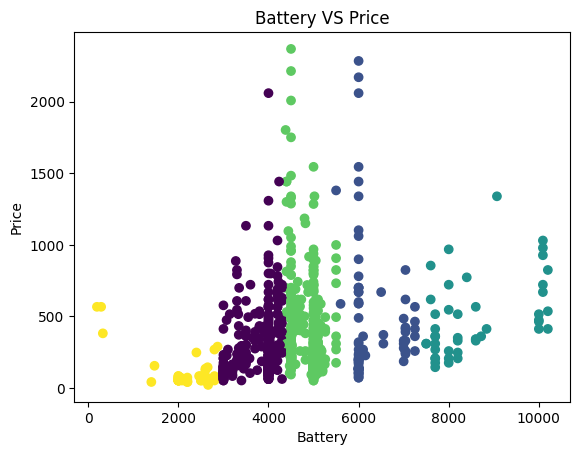

In [18]:

x = detailed_df["battery"].tolist()
y = detailed_df["price"].tolist()
data = list(zip(x, y))
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
plt.scatter(x, y, c=kmeans.labels_)
plt.title('Battery VS Price')
plt.xlabel('Battery')
plt.ylabel('Price')
plt.show()

In [16]:
label_encoder_brand = LabelEncoder()
label_encoder_product = LabelEncoder()

detailed_df['brand_encoded'] = label_encoder_brand.fit_transform(detailed_df['brand'])
detailed_df['product_name_encoded'] = label_encoder_product.fit_transform(detailed_df['product_name'])

detailed_df = detailed_df.drop(columns=['brand', 'product_name'])

X = detailed_df.drop(columns=['price'])
y = detailed_df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 112.2958297272299
Mean Squared Error: 39364.87002909638
